In [54]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
import pickle
plt.rcParams['font.size'] = 20.
plt.rc('axes', labelsize=20) 

In [42]:
nr_neurons = 300;
nr_patterns = 1;

# create an instance of the class HopfieldNetwork with 300 neurons
hopfield_net = network.HopfieldNetwork(nr_neurons = nr_neurons)
#create pattern factory object
factory = pattern_tools.PatternFactory(nr_neurons,1)

 <font size = '5'> 2.1

In [43]:
#Generates a list of nr_patterns patterns with a given average activity
def generate_patterns(nr_patterns = 5, activity = 0.):
    pattern_list = factory.create_random_pattern_list(nr_patterns=nr_patterns, on_probability=activity)
    return pattern_list

#Turns S_i variables into σ_i variables 2.1
def to_σ(S):
    SS = np.copy(S)
    for pattern in SS:
        for p in pattern:
            p[0] = (p[0]+1)/2
    return SS;


<font size = '5'> 2.2

In [44]:
#computes weight matrix from the list of patterns in σ variables 2.2
def weight_matrix(pattern_list,a,b):
    
    N = len(pattern_list[0])
    c = 1/(a*(1-a)*N)
    W = np.zeros((N,N))
        
    for i in range(N):
        for j in range(N):
            for μ in range(len(pattern_list)):
                W[i][j] = W[i][j] + (pattern_list[μ][i][0]-b)*(pattern_list[μ][j][0]-a);
            W[i][j] = W[i][j]*c
        W[i][i] = 0;
    return W

<font size = '5'> 2.3

In [45]:
#computes the hamming distance between two patterns in σ variables
def hamming_distance(P1,P2):
    N = len(P1)
    h = 0
    for i in range(N):
        h = h + 2*(P1[i][0]+P2[i][0]) - 4 * P1[i][0]*P2[i][0]
    return h/(2*N)


<font size = '5'> 2.5

In [46]:
#returns update function    
def update(θ):
    def upd(state_t0,weights):                     
        state_t1 = np.sign(weights@((state_t0 + np.ones(len(state_t0)))/2) - θ)
        return state_t1
    return upd

In [47]:
def Mean_Error_Pattern_Retrieval(nr_patterns = 5, a= 0.5, b = 0.5, θ = 'sumW', max_iter = 1000, verbose = False,flip_percentage = 0.05):
    
    pattern_list = generate_patterns(nr_patterns = nr_patterns,activity = a)
   
   
    if θ == 'sumW':
        hopfield_net.store_patterns(pattern_list)
        W = hopfield_net.weights.copy()
    
        θ = np.zeros(hopfield_net.nrOfNeurons);
        for i in range(len(θ)):
            for j in range(len(θ)):
                if i!=j:
                    θ[i] += W[i,j]/2

    σ_pattern_list = to_σ(pattern_list)
    hopfield_net.weights = weight_matrix(σ_pattern_list,a,b)
    
    hopfield_net.set_dynamics_to_user_function(update(θ))
    
    E = 0;
    accepted_pattern_number = 0
    retrieved_pattern_number = 0
    for μ in range(nr_patterns):    
        noisy_init_state = pattern_tools.flip_n(pattern_list[μ], nr_of_flips=int(flip_percentage*nr_neurons))
        hopfield_net.set_state_from_pattern(noisy_init_state)
        
        #Run until convergence
        count = 0;
        conv = False
        while not conv:
            count = count + 1;
            #print(count)
            state_old = hopfield_net.state.copy();
            hopfield_net.run(nr_steps=1);
            state = hopfield_net.state.copy();
            aux = max(abs(state - state_old))
            conv = (aux<1)
            #print(state == state_old)
            #print(conv)
            if count == max_iter:
                if verbose:
                    print("Network state did not converge for pattern ",μ)
                break
        if conv:
            if verbose:
                print('Pattern %i - Converged after %i iterations'%(μ,count)) 
            accepted_pattern_number = accepted_pattern_number + 1;
        
        state = factory.reshape_patterns([hopfield_net.state])
        h = hamming_distance(to_σ(state)[0],σ_pattern_list[μ])
        if h<0.05:
            retrieved_pattern_number += 1;
        if verbose:
            print("Hamming distance = ",h)
        E = E + h
        
    
    print("Convergence  = %d / %d; Retrieved patterns = %d"%(accepted_pattern_number,nr_patterns,retrieved_pattern_number))

    return E/nr_patterns , retrieved_pattern_number/nr_patterns;

In [8]:
Mean_Error_Pattern_Retrieval(nr_patterns = 5,
                             a = 0.5,
                             b = 0.5,
                             θ = 'sumW',
                             verbose = True)

Pattern 0 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 1 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 2 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 3 - Converged after 2 iterations
Hamming distance =  0.0
Pattern 4 - Converged after 2 iterations
Hamming distance =  0.0
Convergence  = 5 / 5; Retrieved patterns = 5


(0.0, 1.0)

In [9]:
from scipy.interpolate import interp1d
def Evaluate_Mean_Error(M_values,
                        nr_iterations = 5,
                        a= 0.5,
                        b = 0.5,
                        θ = 'sumW',
                        max_iter = 1000,
                        verbose = False,
                        flip_percentage = 0.05):

    E_values =[];
    E_error  =[];
    Nr_values =[];
    Nr_error  =[];

    for M in M_values:
        print(M)
        E_M = [];
        Nr_M = [];
        for run in range(nr_iterations):
            e,n = Mean_Error_Pattern_Retrieval(nr_patterns = M,
                                               a = a,
                                               b = b,
                                               θ = θ,
                                               max_iter = max_iter,
                                               flip_percentage = flip_percentage,
                                               verbose = verbose)
            E_M.append(e);
            Nr_M.append(n);

        E = np.mean(E_M) 
        var_E = np.std(E_M)
        Nr = np.mean(Nr_M) 
        var_Nr = np.std(Nr_M)

        E_values.append(E)
        E_error.append(var_E)
        Nr_values.append(Nr)
        Nr_error.append(var_Nr)
        
        if verbose:
            print('nr of Patterns:',M)
            print("Mean Error: %f +- %f"%(E,var_E))
            print("Fraction: %f +- %f"%(Nr,var_Nr))

        print('\n')
         
    capacity = M_max(M_values,E_values)/nr_neurons
    return E_values,E_error,Nr_values,Nr_error,capacity

def M_max(M_values,E_values,threshold = 0.05):
    C = 0;
    E_interp = interp1d(M_values, E_values, kind='cubic')
    m = np.arange(M_values[0],M_values[-1])
    k = 0
    while (E_interp(m[k+1])-threshold) < 0 and k<(len(m)-2):
        k = k+1
    
    if k<(len(m)-2):
        m_max = m[k]   
    else:
        print('Capacity not Found')
        m_max = m[-1]
    return m_max
    

In [59]:
M_values = [5,10,20,40,50,60,80,100]
E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                   a = 0.5,
                                                                   b=0.5,
                                                                   max_iter = 100,
                                                                   nr_iterations = 8)
DATA = [M_values,E_values,E_error,Nr_values,Nr_error,capacity]
with open("Q2.5_sumW.pickle",'wb') as f:
    pickle.dump(DATA,f)

5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5


10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10


20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Convergence  = 20 / 20; Retrieved patterns = 20
Conv

In [70]:
with open('Q2.5_sumW.pickle','rb') as f:
    DATA = pickle.load(f)
M_values = DATA[0]
E_values = DATA[1]
E_error = DATA[2]
Nr_values = DATA[3]
Nr_error = DATA[4]
capacity = DATA[5]

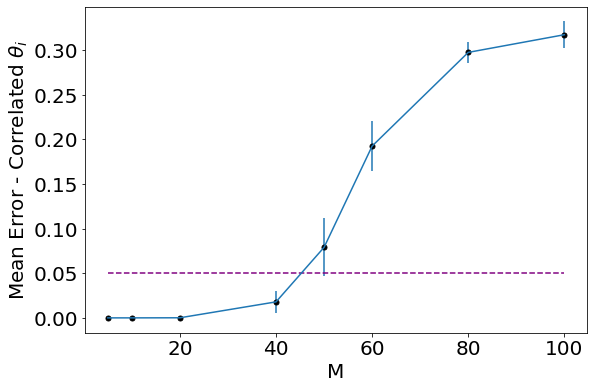

In [71]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,E_values,yerr = E_error,fmt = '-')
plt.plot(M_values,E_values,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.05*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error - Correlated $θ_i$')
plt.show()

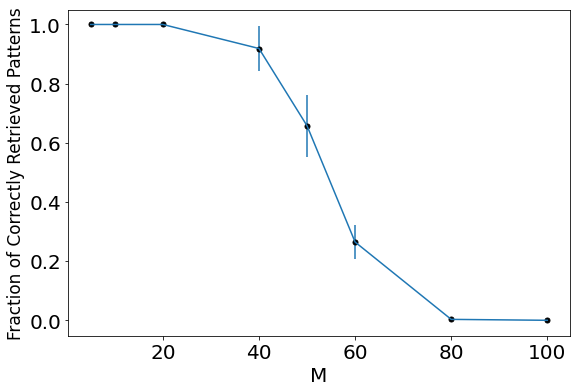

In [72]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,Nr_values,yerr = Nr_error,fmt = '-')
plt.plot(M_values,Nr_values,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns',fontsize = 17)
plt.show()

In [73]:
print("Capacity : ",capacity)

Capacity :  0.15333333333333332


<font size = '5'> Now with $\theta = 0$ 

In [40]:
M_values = [5,10,20,40,50,60,80,100]
E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                   a = 0.5,
                                                                   b=0.5,
                                                                   θ = 0,
                                                                   max_iter = 100,
                                                                   nr_iterations = 8)
DATA = [M_values,E_values,E_error,Nr_values,Nr_error,capacity]
with open("Q2.5.pickle",'wb') as f:
    pickle.dump(DATA,f)

5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5


10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10


20
Convergence  = 19 / 20; Retrieved patterns = 20
Convergence  = 19 / 20; Retrieved patterns = 17
Convergence  = 19 / 20; Retrieved patterns = 14
Convergence  = 18 / 20; Retrieved patterns = 17
Convergence  = 17 / 20; Retrieved patterns = 19
Conv

In [68]:
with open('Q2.5.pickle','rb') as f:
    DATA = pickle.load(f)
M_values = DATA[0]
E_values = DATA[1]
E_error = DATA[2]
Nr_values = DATA[3]
Nr_error = DATA[4]
capacity = DATA[5]

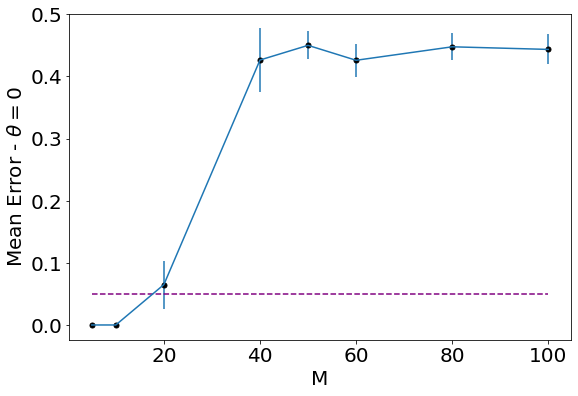

In [69]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,E_values,yerr = E_error,fmt = '-')
plt.plot(M_values,E_values,'.',color = 'k',markersize = 10.)
plt.plot(M_values,0.05*np.ones(len(M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error - $θ = 0$')
plt.show()

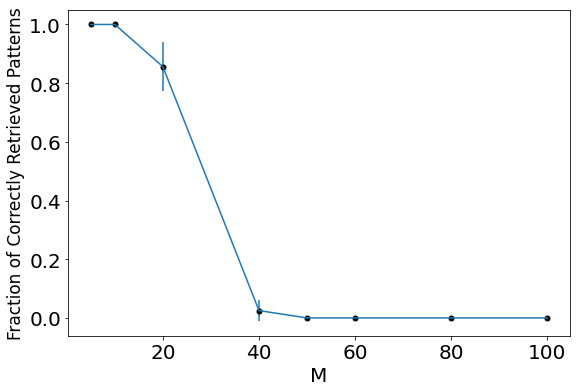

In [58]:
fig = plt.figure(figsize = (9,6))

plt.errorbar(M_values,Nr_values,yerr = Nr_error,fmt = '-')
plt.plot(M_values,Nr_values,'.',color = 'k',markersize = 10.)
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns',fontsize = 17)
plt.show()

In [51]:
print("Capacity : ",capacity)

Capacity :  0.06


<font size="5">
2.6

In [11]:
#now for many θs :

a = 0.5
b = 0.5
θ_vals = np.arange(-0.5, 0.6,0.1)
print(θ_vals)
M_values = np.concatenate((np.array([1,2,3,4,5]),np.arange(10,110,10)))
print(M_values)
EE_values =[]
EE_errors =[]
NNr_values=[]
NNr_errors=[]
Capacities=[]

for θ in θ_vals:
    print("θ: ",θ)
    E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                       a = a,
                                                                       b = b,
                                                                       θ = θ, 
                                                                       max_iter = 100,
                                                                       nr_iterations = 5,
                                                                       )
    
    EE_values.append(E_values)
    EE_errors.append(E_error)
    NNr_values.append(Nr_values)
    NNr_errors.append(Nr_error)
    Capacities.append(capacity)

DATA = [θ_vals,M_values,EE_values,EE_errors,NNr_values,NNr_errors,Capacities]
with open('theta.pickle', 'wb') as f:
    pickle.dump(DATA, f)

[-5.00000000e-01 -4.00000000e-01 -3.00000000e-01 -2.00000000e-01
 -1.00000000e-01 -1.11022302e-16  1.00000000e-01  2.00000000e-01
  3.00000000e-01  4.00000000e-01  5.00000000e-01]
[  1   2   3   4   5  10  20  30  40  50  60  70  80  90 100]
θ:  -0.5
1
Convergence  = 1 / 1; Retrieved patterns = 0
Convergence  = 1 / 1; Retrieved patterns = 0
Convergence  = 1 / 1; Retrieved patterns = 0
Convergence  = 1 / 1; Retrieved patterns = 0
Convergence  = 1 / 1; Retrieved patterns = 0


2
Convergence  = 2 / 2; Retrieved patterns = 0
Convergence  = 2 / 2; Retrieved patterns = 0
Convergence  = 2 / 2; Retrieved patterns = 0
Convergence  = 2 / 2; Retrieved patterns = 0
Convergence  = 2 / 2; Retrieved patterns = 0


3
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 0


4
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 

Convergence  = 4 / 4; Retrieved patterns = 4
Convergence  = 4 / 4; Retrieved patterns = 4


5
Convergence  = 5 / 5; Retrieved patterns = 1
Convergence  = 5 / 5; Retrieved patterns = 4
Convergence  = 5 / 5; Retrieved patterns = 3
Convergence  = 5 / 5; Retrieved patterns = 3
Convergence  = 5 / 5; Retrieved patterns = 4


10
Convergence  = 9 / 10; Retrieved patterns = 1
Convergence  = 8 / 10; Retrieved patterns = 0
Convergence  = 10 / 10; Retrieved patterns = 3
Convergence  = 9 / 10; Retrieved patterns = 1
Convergence  = 8 / 10; Retrieved patterns = 0


20
Convergence  = 18 / 20; Retrieved patterns = 0
Convergence  = 14 / 20; Retrieved patterns = 0
Convergence  = 13 / 20; Retrieved patterns = 0
Convergence  = 15 / 20; Retrieved patterns = 0
Convergence  = 16 / 20; Retrieved patterns = 0


30
Convergence  = 19 / 30; Retrieved patterns = 0
Convergence  = 19 / 30; Retrieved patterns = 0
Convergence  = 23 / 30; Retrieved patterns = 0
Convergence  = 23 / 30; Retrieved patterns = 0
Convergence 

Convergence  = 29 / 40; Retrieved patterns = 0
Convergence  = 23 / 40; Retrieved patterns = 0
Convergence  = 31 / 40; Retrieved patterns = 2
Convergence  = 34 / 40; Retrieved patterns = 0
Convergence  = 30 / 40; Retrieved patterns = 0


50
Convergence  = 28 / 50; Retrieved patterns = 0
Convergence  = 37 / 50; Retrieved patterns = 0
Convergence  = 35 / 50; Retrieved patterns = 0
Convergence  = 28 / 50; Retrieved patterns = 0
Convergence  = 32 / 50; Retrieved patterns = 0


60
Convergence  = 41 / 60; Retrieved patterns = 0
Convergence  = 35 / 60; Retrieved patterns = 0
Convergence  = 36 / 60; Retrieved patterns = 0
Convergence  = 34 / 60; Retrieved patterns = 0
Convergence  = 39 / 60; Retrieved patterns = 0


70
Convergence  = 44 / 70; Retrieved patterns = 0
Convergence  = 44 / 70; Retrieved patterns = 0
Convergence  = 38 / 70; Retrieved patterns = 0
Convergence  = 48 / 70; Retrieved patterns = 0
Convergence  = 40 / 70; Retrieved patterns = 0


80
Convergence  = 52 / 80; Retrieved patter

Convergence  = 49 / 80; Retrieved patterns = 0
Convergence  = 43 / 80; Retrieved patterns = 0
Convergence  = 45 / 80; Retrieved patterns = 0


90
Convergence  = 52 / 90; Retrieved patterns = 0
Convergence  = 55 / 90; Retrieved patterns = 0
Convergence  = 49 / 90; Retrieved patterns = 0
Convergence  = 44 / 90; Retrieved patterns = 0
Convergence  = 56 / 90; Retrieved patterns = 0


100
Convergence  = 64 / 100; Retrieved patterns = 0
Convergence  = 53 / 100; Retrieved patterns = 0
Convergence  = 40 / 100; Retrieved patterns = 0
Convergence  = 48 / 100; Retrieved patterns = 0
Convergence  = 44 / 100; Retrieved patterns = 0


θ:  0.19999999999999984
1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1


2
Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retr

Convergence  = 2 / 2; Retrieved patterns = 1


3
Convergence  = 3 / 3; Retrieved patterns = 1
Convergence  = 3 / 3; Retrieved patterns = 1
Convergence  = 3 / 3; Retrieved patterns = 2
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 1


4
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 4 / 4; Retrieved patterns = 1
Convergence  = 4 / 4; Retrieved patterns = 0


5
Convergence  = 5 / 5; Retrieved patterns = 0
Convergence  = 5 / 5; Retrieved patterns = 0
Convergence  = 5 / 5; Retrieved patterns = 0
Convergence  = 5 / 5; Retrieved patterns = 0
Convergence  = 5 / 5; Retrieved patterns = 1


10
Convergence  = 10 / 10; Retrieved patterns = 0
Convergence  = 10 / 10; Retrieved patterns = 0
Convergence  = 10 / 10; Retrieved patterns = 0
Convergence  = 10 / 10; Retrieved patterns = 0
Convergence  = 10 / 10; Retrieved patterns = 0


20
Convergence  = 15 / 20;

In [74]:
f = open('theta.pickle','rb') 
DATA = pickle.load(f)
f.close()
_θ_vals = DATA[0];
_M_values = DATA[1];
_EE_values = DATA[2];
_EE_errors = DATA[3];
_NNr_values = DATA[4];
_NNr_errors = DATA[5];
_Capacities = DATA[6];

θ_0 = _θ_vals;
Capacities_0 = _Capacities;

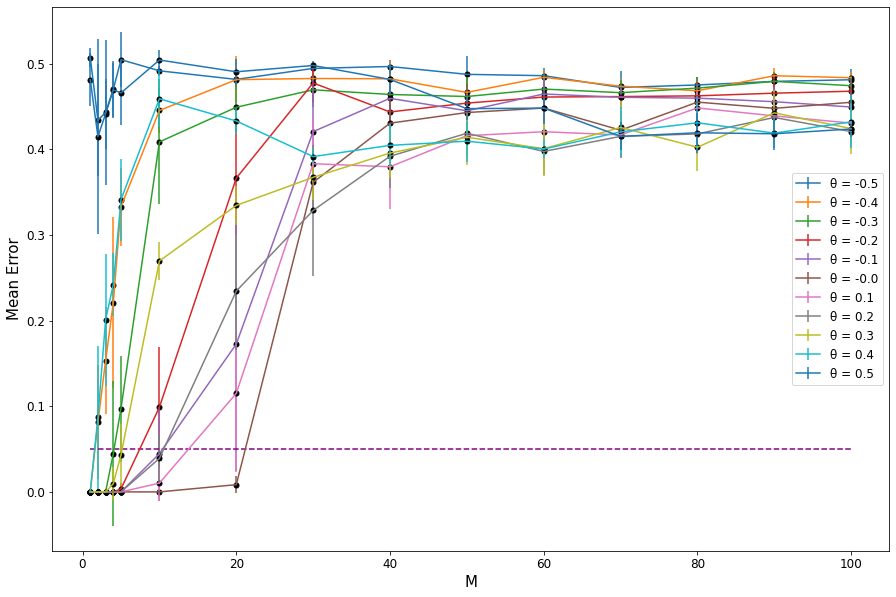

In [26]:
fig = plt.figure(figsize = (15,10))
for i in range(len(_θ_vals)):
    plt.errorbar(_M_values,_EE_values[i],yerr = _EE_errors[i],fmt = '-',label = 'θ = %.1f'%(_θ_vals[i]))
    plt.plot(_M_values,_EE_values[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

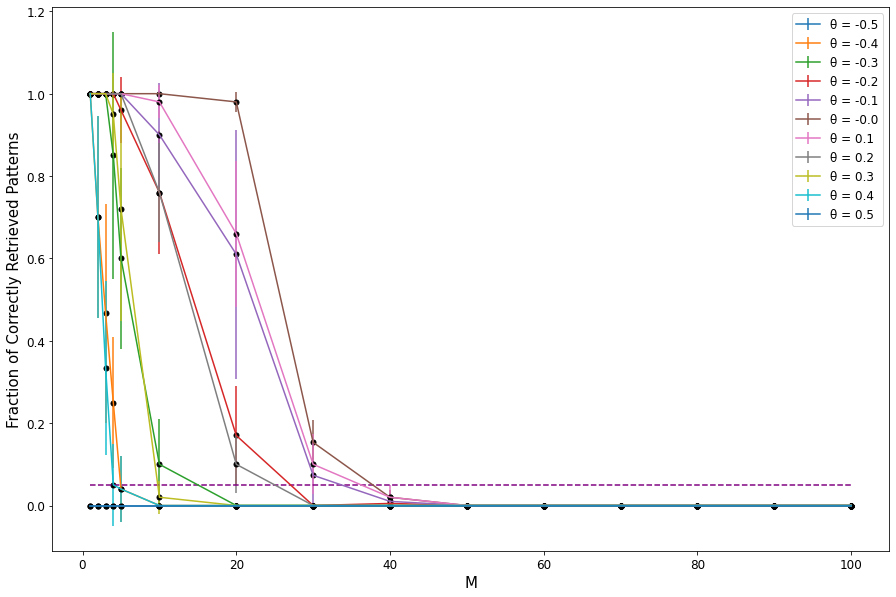

In [9]:
fig = plt.figure(figsize = (15,10))
for i in range(len(_θ_vals)):
    plt.errorbar(_M_values,_NNr_values[i],yerr = _NNr_errors[i],fmt = '-',label = 'θ = %.1f'%(_θ_vals[i]))
    plt.plot(_M_values,_NNr_values[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns')
plt.legend()
plt.show()

Text(0, 0.5, 'Capacity')

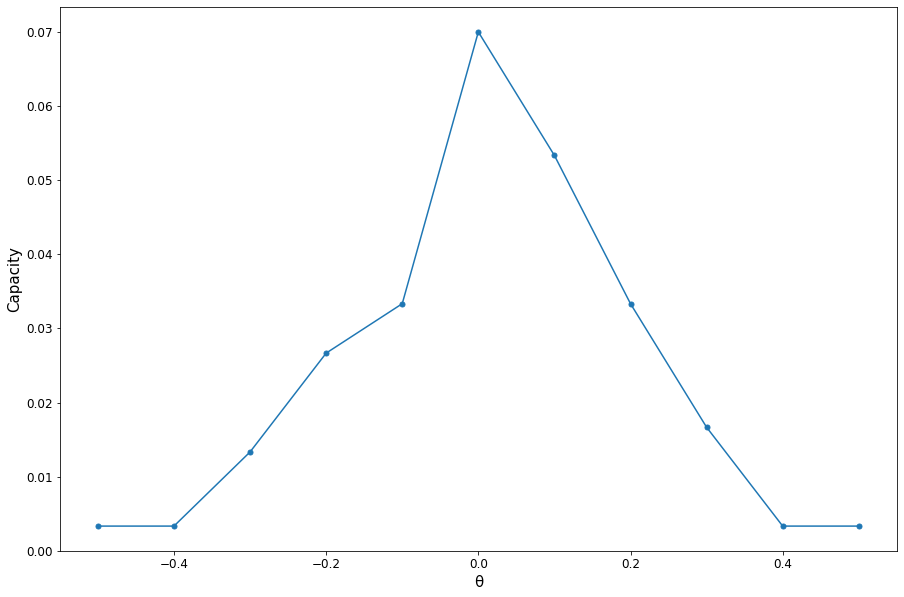

In [17]:
fig = plt.figure(figsize = (15,10))
plt.plot(_θ_vals,_Capacities,'.-',markersize = 10)

#plt.plot(n_range,theo_cps)
plt.xlabel('θ')
plt.ylabel('Capacity')

In [85]:
#now for many θs :

a = 0.1
b = 0.1
θ_vals = np.arange(0., 1.1,0.1)
print(θ_vals)
M_values = np.concatenate((np.array([1,2,3,4,5]),np.arange(10,150,10)))
print(M_values)
EE_values =[]
EE_errors =[]
NNr_values=[]
NNr_errors=[]
Capacities=[]

for θ in θ_vals:
    print("θ: ",θ)
    E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                       a = a,
                                                                       b = b,
                                                                       θ = θ, 
                                                                       max_iter = 100,
                                                                       nr_iterations = 1,
                                                                       )
    
    EE_values.append(E_values)
    EE_errors.append(E_error)
    NNr_values.append(Nr_values)
    NNr_errors.append(Nr_error)
    Capacities.append(capacity)

DATA = [θ_vals,M_values,EE_values,EE_errors,NNr_values,NNr_errors,Capacities]
with open('theta_01.pickle', 'wb') as f:
    pickle.dump(DATA, f)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[  1   2   3   4   5  10  20  30  40  50  60  70  80  90 100 110 120 130
 140]
θ:  0.0
1
Convergence  = 1 / 1; Retrieved patterns = 1


2
Convergence  = 2 / 2; Retrieved patterns = 2


3
Convergence  = 3 / 3; Retrieved patterns = 3


4
Convergence  = 4 / 4; Retrieved patterns = 3


5
Convergence  = 5 / 5; Retrieved patterns = 3


10
Convergence  = 10 / 10; Retrieved patterns = 0


20
Convergence  = 19 / 20; Retrieved patterns = 0


30
Convergence  = 26 / 30; Retrieved patterns = 0


40
Convergence  = 24 / 40; Retrieved patterns = 0


50
Convergence  = 37 / 50; Retrieved patterns = 0


60
Convergence  = 34 / 60; Retrieved patterns = 0


70
Convergence  = 35 / 70; Retrieved patterns = 0


80
Convergence  = 48 / 80; Retrieved patterns = 0


90
Convergence  = 68 / 90; Retrieved patterns = 0


100
Convergence  = 53 / 100; Retrieved patterns = 0


110
Convergence  = 55 / 110; Retrieved patterns = 0


120
Convergence  = 55 / 120; Retrieved pattern

Convergence  = 2 / 2; Retrieved patterns = 0


3
Convergence  = 3 / 3; Retrieved patterns = 2


4
Convergence  = 4 / 4; Retrieved patterns = 1


5
Convergence  = 5 / 5; Retrieved patterns = 0


10
Convergence  = 10 / 10; Retrieved patterns = 4


20
Convergence  = 20 / 20; Retrieved patterns = 4


30
Convergence  = 30 / 30; Retrieved patterns = 5


40
Convergence  = 40 / 40; Retrieved patterns = 2


50
Convergence  = 50 / 50; Retrieved patterns = 9


60
Convergence  = 59 / 60; Retrieved patterns = 10


70
Convergence  = 70 / 70; Retrieved patterns = 2


80
Convergence  = 79 / 80; Retrieved patterns = 5


90
Convergence  = 89 / 90; Retrieved patterns = 4


100
Convergence  = 100 / 100; Retrieved patterns = 8


110
Convergence  = 107 / 110; Retrieved patterns = 9


120
Convergence  = 119 / 120; Retrieved patterns = 4


130
Convergence  = 130 / 130; Retrieved patterns = 8


140
Convergence  = 136 / 140; Retrieved patterns = 8


θ:  0.9
1
Convergence  = 1 / 1; Retrieved patterns = 0


2
Con

In [86]:
f = open('theta_01.pickle','rb') 
DATA = pickle.load(f)
f.close()
_θ_vals = DATA[0];
_M_values = DATA[1];
_EE_values = DATA[2];
_EE_errors = DATA[3];
_NNr_values = DATA[4];
_NNr_errors = DATA[5];
_Capacities = DATA[6];

θ_01 = _θ_vals;
Capacities_01 = _Capacities;

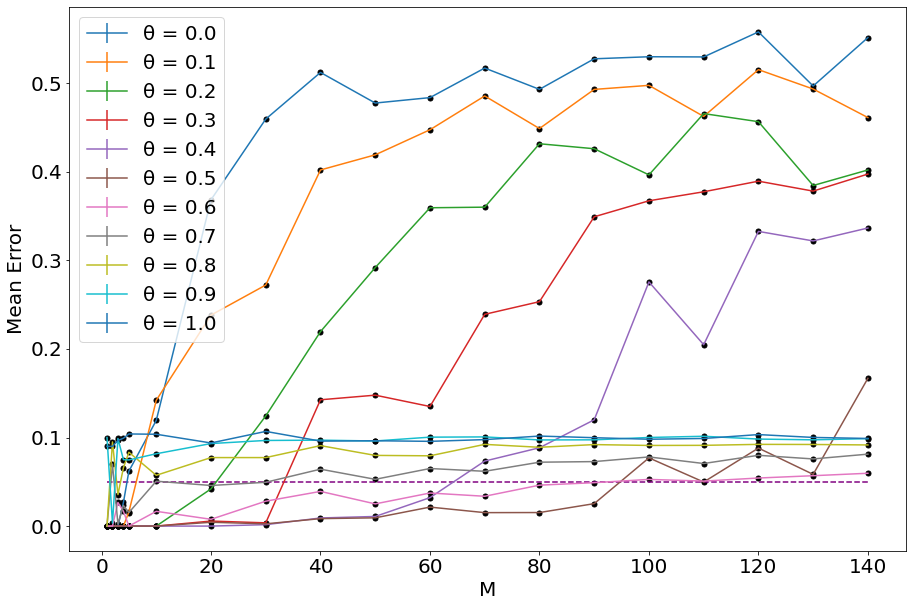

In [87]:
fig = plt.figure(figsize = (15,10))
for i in range(len(_θ_vals)):
    plt.errorbar(_M_values,_EE_values[i],yerr = _EE_errors[i],fmt = '-',label = 'θ = %.1f'%(_θ_vals[i]))
    plt.plot(_M_values,_EE_values[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

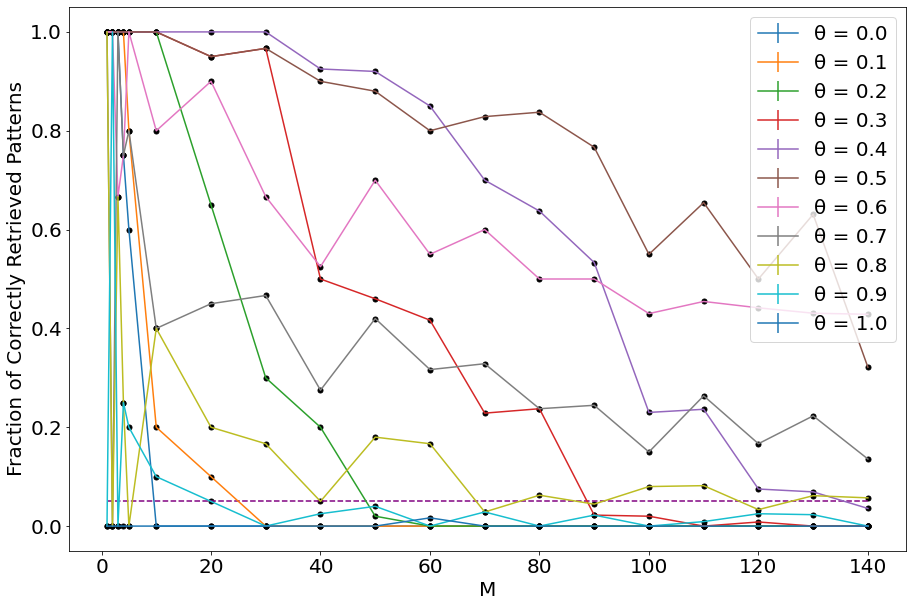

In [88]:
fig = plt.figure(figsize = (15,10))
for i in range(len(_θ_vals)):
    plt.errorbar(_M_values,_NNr_values[i],yerr = _NNr_errors[i],fmt = '-',label = 'θ = %.1f'%(_θ_vals[i]))
    plt.plot(_M_values,_NNr_values[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Fraction of Correctly Retrieved Patterns')

plt.legend()
plt.show()

Text(0, 0.5, 'Capacity')

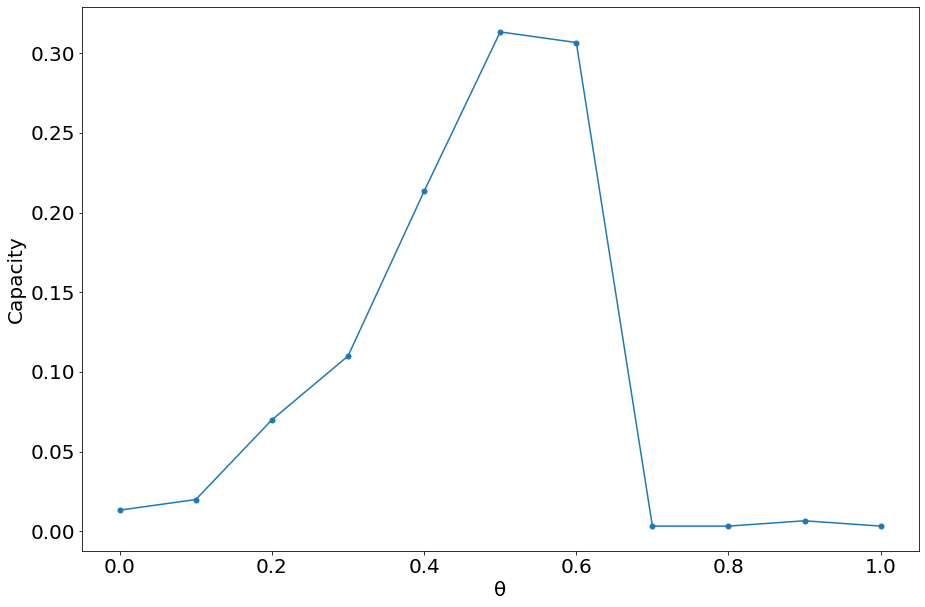

In [89]:
fig = plt.figure(figsize = (15,10))
plt.plot(_θ_vals,_Capacities,'.-',markersize = 10)

#plt.plot(n_range,theo_cps)
plt.xlabel('θ')
plt.ylabel('Capacity')

In [90]:
#now for many θs :

a = 0.05
b = 0.05
θ_vals = np.arange(0., 1.5,0.1)
print(θ_vals)
M_values = np.concatenate((np.array([1,2,3,4,5]),np.arange(10,140,10)))
print(M_values)
EE_values =[]
EE_errors =[]
NNr_values=[]
NNr_errors=[]
Capacities=[]

for θ in θ_vals:
    print("θ: ",θ)
    E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                       a = a,
                                                                       b = b,
                                                                       θ = θ, 
                                                                       max_iter = 100,
                                                                       nr_iterations = 1,
                                                                       )
    
    EE_values.append(E_values)
    EE_errors.append(E_error)
    NNr_values.append(Nr_values)
    NNr_errors.append(Nr_error)
    Capacities.append(capacity)

DATA = [θ_vals,M_values,EE_values,EE_errors,NNr_values,NNr_errors,Capacities]
with open('theta_005.pickle', 'wb') as f:
    pickle.dump(DATA, f)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]
[  1   2   3   4   5  10  20  30  40  50  60  70  80  90 100 110 120 130]
θ:  0.0
1
Convergence  = 1 / 1; Retrieved patterns = 1


2
Convergence  = 2 / 2; Retrieved patterns = 2


3
Convergence  = 3 / 3; Retrieved patterns = 2


4
Convergence  = 4 / 4; Retrieved patterns = 1


5
Convergence  = 5 / 5; Retrieved patterns = 1


10
Convergence  = 10 / 10; Retrieved patterns = 0


20
Convergence  = 19 / 20; Retrieved patterns = 0


30
Convergence  = 28 / 30; Retrieved patterns = 0


40
Convergence  = 30 / 40; Retrieved patterns = 0


50
Convergence  = 36 / 50; Retrieved patterns = 0


60
Convergence  = 35 / 60; Retrieved patterns = 0


70
Convergence  = 41 / 70; Retrieved patterns = 0


80
Convergence  = 54 / 80; Retrieved patterns = 0


90
Convergence  = 52 / 90; Retrieved patterns = 0


100
Convergence  = 67 / 100; Retrieved patterns = 0


110
Convergence  = 59 / 110; Retrieved patterns = 0


120
Convergence  = 49 / 120; Retrie

Convergence  = 40 / 40; Retrieved patterns = 27


50
Convergence  = 49 / 50; Retrieved patterns = 36


60
Convergence  = 60 / 60; Retrieved patterns = 49


70
Convergence  = 70 / 70; Retrieved patterns = 53


80
Convergence  = 80 / 80; Retrieved patterns = 60


90
Convergence  = 89 / 90; Retrieved patterns = 66


100
Convergence  = 100 / 100; Retrieved patterns = 58


110
Convergence  = 110 / 110; Retrieved patterns = 78


120
Convergence  = 117 / 120; Retrieved patterns = 96


130
Convergence  = 130 / 130; Retrieved patterns = 87


Capacity not Found
θ:  0.9
1
Convergence  = 1 / 1; Retrieved patterns = 0


2
Convergence  = 2 / 2; Retrieved patterns = 1


3
Convergence  = 3 / 3; Retrieved patterns = 3


4
Convergence  = 4 / 4; Retrieved patterns = 3


5
Convergence  = 5 / 5; Retrieved patterns = 3


10
Convergence  = 10 / 10; Retrieved patterns = 9


20
Convergence  = 20 / 20; Retrieved patterns = 15


30
Convergence  = 29 / 30; Retrieved patterns = 20


40
Convergence  = 40 / 40; Retr

In [91]:
f = open('theta_005.pickle','rb') 
DATA = pickle.load(f)
f.close()
_θ_vals = DATA[0];
_M_values = DATA[1];
_EE_values = DATA[2];
_EE_errors = DATA[3];
_NNr_values = DATA[4];
_NNr_errors = DATA[5];
_Capacities = DATA[6];

θ_005 = _θ_vals;
Capacities_005 = _Capacities;

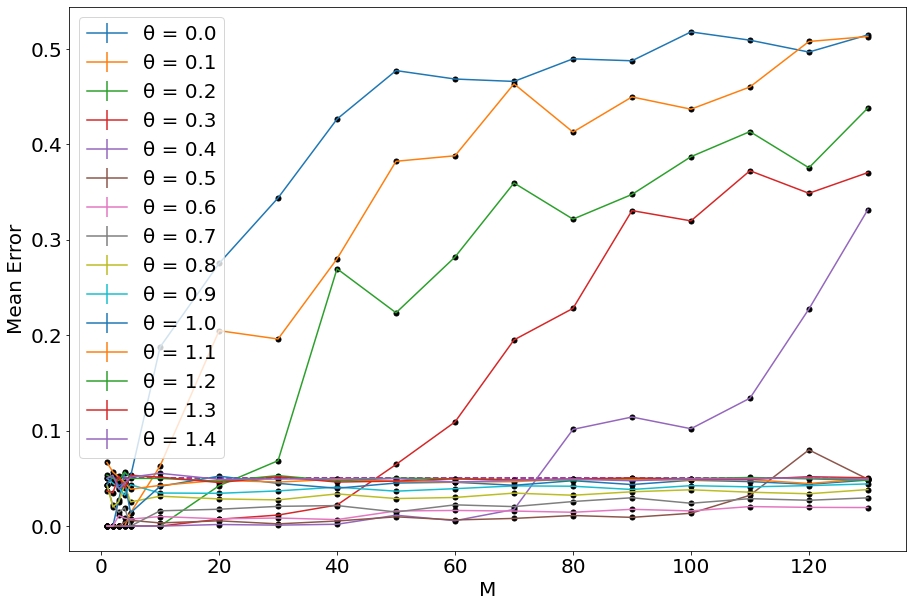

In [92]:
fig = plt.figure(figsize = (15,10))
for i in range(len(_θ_vals)):
    plt.errorbar(_M_values,_EE_values[i],yerr = _EE_errors[i],fmt = '-',label = 'θ = %.1f'%(_θ_vals[i]))
    plt.plot(_M_values,_EE_values[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

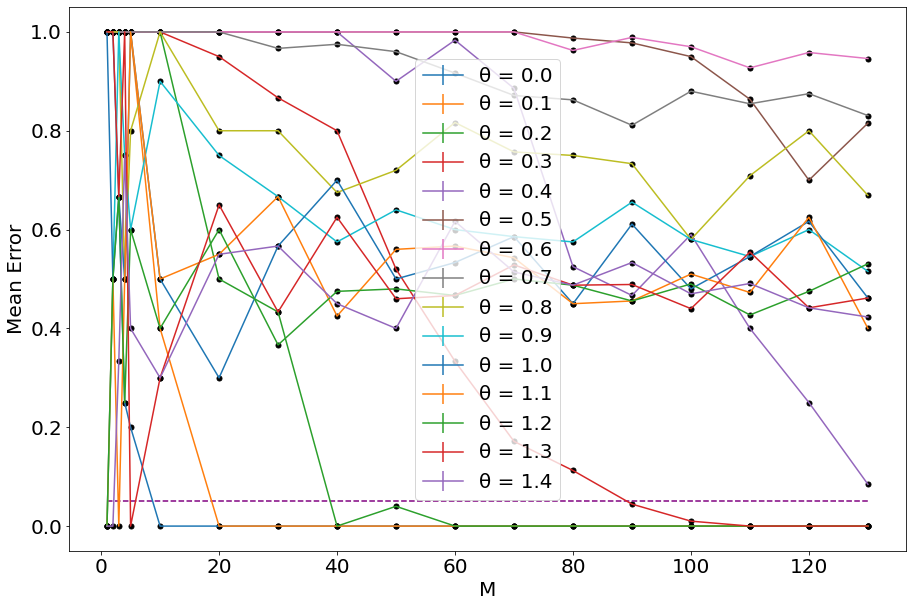

In [93]:
fig = plt.figure(figsize = (15,10))
for i in range(len(_θ_vals)):
    plt.errorbar(_M_values,_NNr_values[i],yerr = _NNr_errors[i],fmt = '-',label = 'θ = %.1f'%(_θ_vals[i]))
    plt.plot(_M_values,_NNr_values[i],'.',color = 'k',markersize = 10.)


plt.plot(_M_values,0.05*np.ones(len(_M_values)),'--',color = 'purple')
plt.xlabel('M')
plt.ylabel('Mean Error')
plt.legend()
plt.show()

Text(0, 0.5, 'Capacity')

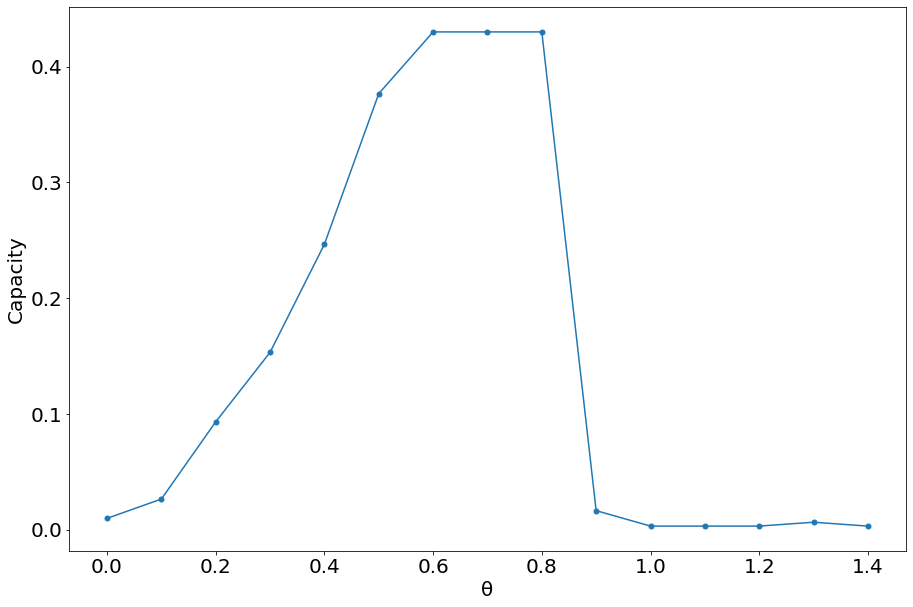

In [95]:
fig = plt.figure(figsize = (15,10))
plt.plot(_θ_vals,_Capacities,'.-',markersize = 10)

#plt.plot(n_range,theo_cps)
plt.xlabel('θ')
plt.ylabel('Capacity')

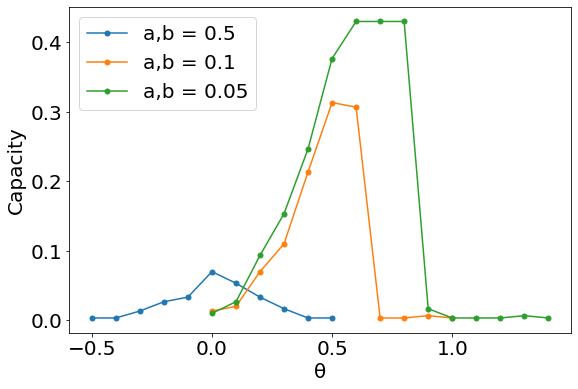

In [96]:
fig = plt.figure(figsize =(9,6))
plt.plot(θ_0,Capacities_0,'.-',markersize = 10,label = "a,b = 0.5")
plt.plot(θ_01,Capacities_01,'.-',markersize = 10,label = "a,b = 0.1")
plt.plot(θ_005,Capacities_005,'.-',markersize = 10,label = "a,b = 0.05")


#plt.plot(n_range,theo_cps)
plt.xlabel('θ')
plt.ylabel('Capacity')
plt.legend()

<font size = '5'> 2.8

In [30]:
b_vals = [0, 0.05, 0.2, 0.5, 0.8]
θ_vals = [0., 0.1, 0.2, 0.5,1.]

In [31]:
#now vary theta and b

a = 0.1
b = 0.1

M_values = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,120,140]
print(M_values)

EEE_values =[]
EEE_errors =[]
NNNr_values=[]
NNNr_errors=[]
CCapacities=[]


for θ in θ_vals:
    print("θ: ",θ)
    
    EE_values =[]
    EE_errors =[]
    NNr_values=[]
    NNr_errors=[]
    Capacities=[]

    for b in b_vals:
        print("b = ",b)
        E_values,E_error,Nr_values,Nr_error,capacity = Evaluate_Mean_Error(M_values,
                                                                           a = a,
                                                                           b = b,
                                                                           θ = θ, 
                                                                           max_iter = 100,
                                                                           nr_iterations = 4,
                                                                           )

        EE_values.append(E_values)
        EE_errors.append(E_error)
        NNr_values.append(Nr_values)
        NNr_errors.append(Nr_error)
        Capacities.append(capacity)
        
    EEE_values.append(EE_values)
    EEE_errors.append(EE_errors)
    NNNr_values.append(NNr_values)
    NNNr_errors.append(NNr_errors)
    CCapacities.append(Capacities)
    
    
DATA = [θ_vals,b_vals,M_values,EEE_values,EEE_errors,NNNr_values,NNNr_errors,CCapacities]


with open('theta_b.pickle', 'wb') as f:
    pickle.dump(DATA, f)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
θ:  0.0
b =  0
1
Convergence  = 1 / 1; Retrieved patterns = 0
Convergence  = 1 / 1; Retrieved patterns = 0
Convergence  = 1 / 1; Retrieved patterns = 0
Convergence  = 1 / 1; Retrieved patterns = 0


2
Convergence  = 2 / 2; Retrieved patterns = 0
Convergence  = 2 / 2; Retrieved patterns = 0
Convergence  = 2 / 2; Retrieved patterns = 0
Convergence  = 2 / 2; Retrieved patterns = 0


3
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 0
Convergence  = 3 / 3; Retrieved patterns = 0


4
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 4 / 4; Retrieved patterns = 0


5
Convergence  = 5 / 5; Retrieved patterns = 0
Convergence  = 5 / 5; Retrieved patterns = 0
Convergence  = 5 / 5; Retrieved patterns = 0
Convergence  = 5 / 5; Retrieved patterns = 

Convergence  = 6 / 6; Retrieved patterns = 6
Convergence  = 6 / 6; Retrieved patterns = 6
Convergence  = 6 / 6; Retrieved patterns = 5
Convergence  = 6 / 6; Retrieved patterns = 6


7
Convergence  = 7 / 7; Retrieved patterns = 6
Convergence  = 7 / 7; Retrieved patterns = 7
Convergence  = 7 / 7; Retrieved patterns = 6
Convergence  = 7 / 7; Retrieved patterns = 6


8
Convergence  = 8 / 8; Retrieved patterns = 8
Convergence  = 8 / 8; Retrieved patterns = 7
Convergence  = 8 / 8; Retrieved patterns = 4
Convergence  = 8 / 8; Retrieved patterns = 7


9
Convergence  = 9 / 9; Retrieved patterns = 6
Convergence  = 9 / 9; Retrieved patterns = 7
Convergence  = 9 / 9; Retrieved patterns = 5
Convergence  = 9 / 9; Retrieved patterns = 4


10
Convergence  = 9 / 10; Retrieved patterns = 8
Convergence  = 10 / 10; Retrieved patterns = 7
Convergence  = 10 / 10; Retrieved patterns = 7
Convergence  = 10 / 10; Retrieved patterns = 7


20
Convergence  = 19 / 20; Retrieved patterns = 2
Convergence  = 19 / 20; 

Convergence  = 20 / 20; Retrieved patterns = 17
Convergence  = 19 / 20; Retrieved patterns = 17
Convergence  = 19 / 20; Retrieved patterns = 13


30
Convergence  = 19 / 30; Retrieved patterns = 13
Convergence  = 23 / 30; Retrieved patterns = 19
Convergence  = 20 / 30; Retrieved patterns = 14
Convergence  = 29 / 30; Retrieved patterns = 15


40
Convergence  = 40 / 40; Retrieved patterns = 24
Convergence  = 28 / 40; Retrieved patterns = 20
Convergence  = 23 / 40; Retrieved patterns = 12
Convergence  = 37 / 40; Retrieved patterns = 15


50
Convergence  = 44 / 50; Retrieved patterns = 24
Convergence  = 22 / 50; Retrieved patterns = 12
Convergence  = 18 / 50; Retrieved patterns = 6
Convergence  = 47 / 50; Retrieved patterns = 25


60
Convergence  = 48 / 60; Retrieved patterns = 29
Convergence  = 22 / 60; Retrieved patterns = 10
Convergence  = 26 / 60; Retrieved patterns = 14
Convergence  = 19 / 60; Retrieved patterns = 12


70
Convergence  = 57 / 70; Retrieved patterns = 19
Convergence  = 2

Convergence  = 38 / 70; Retrieved patterns = 0
Convergence  = 40 / 70; Retrieved patterns = 0
Convergence  = 40 / 70; Retrieved patterns = 0


80
Convergence  = 48 / 80; Retrieved patterns = 0
Convergence  = 43 / 80; Retrieved patterns = 0
Convergence  = 43 / 80; Retrieved patterns = 0
Convergence  = 42 / 80; Retrieved patterns = 0


90
Convergence  = 44 / 90; Retrieved patterns = 0
Convergence  = 49 / 90; Retrieved patterns = 0
Convergence  = 56 / 90; Retrieved patterns = 0
Convergence  = 58 / 90; Retrieved patterns = 0


100
Convergence  = 64 / 100; Retrieved patterns = 0
Convergence  = 51 / 100; Retrieved patterns = 0
Convergence  = 47 / 100; Retrieved patterns = 0
Convergence  = 52 / 100; Retrieved patterns = 0


b =  0.2
1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1


2
Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retrieved p

Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retrieved patterns = 2


3
Convergence  = 3 / 3; Retrieved patterns = 2
Convergence  = 3 / 3; Retrieved patterns = 2
Convergence  = 3 / 3; Retrieved patterns = 2
Convergence  = 3 / 3; Retrieved patterns = 1


4
Convergence  = 4 / 4; Retrieved patterns = 2
Convergence  = 4 / 4; Retrieved patterns = 4
Convergence  = 4 / 4; Retrieved patterns = 2
Convergence  = 4 / 4; Retrieved patterns = 1


5
Convergence  = 5 / 5; Retrieved patterns = 2
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5
Convergence  = 5 / 5; Retrieved patterns = 5


6
Convergence  = 6 / 6; Retrieved patterns = 5
Convergence  = 6 / 6; Retrieved patterns = 1
Convergence  = 6 / 6; Retrieved patterns = 5
Convergence  = 6 / 6; Retrieved patterns = 2


7
Convergence  = 7 / 7; Retrieved patterns = 5
Convergence  = 7 / 7; Retrieved patterns = 6
Convergence  = 7 / 7; Retrieved pat

Convergence  = 7 / 7; Retrieved patterns = 5
Convergence  = 7 / 7; Retrieved patterns = 7


8
Convergence  = 8 / 8; Retrieved patterns = 8
Convergence  = 8 / 8; Retrieved patterns = 8
Convergence  = 8 / 8; Retrieved patterns = 7
Convergence  = 8 / 8; Retrieved patterns = 7


9
Convergence  = 9 / 9; Retrieved patterns = 8
Convergence  = 9 / 9; Retrieved patterns = 8
Convergence  = 9 / 9; Retrieved patterns = 9
Convergence  = 9 / 9; Retrieved patterns = 4


10
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 9
Convergence  = 10 / 10; Retrieved patterns = 10
Convergence  = 10 / 10; Retrieved patterns = 10


20
Convergence  = 18 / 20; Retrieved patterns = 7
Convergence  = 20 / 20; Retrieved patterns = 10
Convergence  = 18 / 20; Retrieved patterns = 11
Convergence  = 16 / 20; Retrieved patterns = 0


30
Convergence  = 29 / 30; Retrieved patterns = 10
Convergence  = 28 / 30; Retrieved patterns = 9
Convergence  = 26 / 30; Retrieved patterns = 0
Conv

Convergence  = 30 / 30; Retrieved patterns = 23


40
Convergence  = 40 / 40; Retrieved patterns = 24
Convergence  = 39 / 40; Retrieved patterns = 30
Convergence  = 40 / 40; Retrieved patterns = 27
Convergence  = 37 / 40; Retrieved patterns = 18


50
Convergence  = 49 / 50; Retrieved patterns = 40
Convergence  = 48 / 50; Retrieved patterns = 35
Convergence  = 49 / 50; Retrieved patterns = 31
Convergence  = 50 / 50; Retrieved patterns = 38


60
Convergence  = 58 / 60; Retrieved patterns = 29
Convergence  = 59 / 60; Retrieved patterns = 35
Convergence  = 58 / 60; Retrieved patterns = 18
Convergence  = 53 / 60; Retrieved patterns = 52


70
Convergence  = 63 / 70; Retrieved patterns = 41
Convergence  = 66 / 70; Retrieved patterns = 32
Convergence  = 67 / 70; Retrieved patterns = 35
Convergence  = 66 / 70; Retrieved patterns = 45


80
Convergence  = 74 / 80; Retrieved patterns = 37
Convergence  = 74 / 80; Retrieved patterns = 32
Convergence  = 77 / 80; Retrieved patterns = 37
Convergence  = 

Convergence  = 64 / 80; Retrieved patterns = 40
Convergence  = 63 / 80; Retrieved patterns = 39


90
Convergence  = 70 / 90; Retrieved patterns = 54
Convergence  = 44 / 90; Retrieved patterns = 22
Convergence  = 55 / 90; Retrieved patterns = 26
Convergence  = 54 / 90; Retrieved patterns = 39


100
Convergence  = 77 / 100; Retrieved patterns = 40
Convergence  = 79 / 100; Retrieved patterns = 55
Convergence  = 66 / 100; Retrieved patterns = 22
Convergence  = 60 / 100; Retrieved patterns = 30


b =  0.05
1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1
Convergence  = 1 / 1; Retrieved patterns = 1


2
Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retrieved patterns = 2
Convergence  = 2 / 2; Retrieved patterns = 1


3
Convergence  = 3 / 3; Retrieved patterns = 3
Convergence  = 3 / 3; Retrieved patterns = 3
Convergence  = 3 / 3; Retrieved p

Convergence  = 3 / 3; Retrieved patterns = 1
Convergence  = 3 / 3; Retrieved patterns = 1
Convergence  = 3 / 3; Retrieved patterns = 0


4
Convergence  = 4 / 4; Retrieved patterns = 1
Convergence  = 4 / 4; Retrieved patterns = 0
Convergence  = 4 / 4; Retrieved patterns = 1
Convergence  = 4 / 4; Retrieved patterns = 1


5
Convergence  = 5 / 5; Retrieved patterns = 1
Convergence  = 5 / 5; Retrieved patterns = 1
Convergence  = 5 / 5; Retrieved patterns = 2
Convergence  = 5 / 5; Retrieved patterns = 1


6
Convergence  = 6 / 6; Retrieved patterns = 0
Convergence  = 6 / 6; Retrieved patterns = 2
Convergence  = 6 / 6; Retrieved patterns = 1
Convergence  = 6 / 6; Retrieved patterns = 3


7
Convergence  = 7 / 7; Retrieved patterns = 2
Convergence  = 7 / 7; Retrieved patterns = 1
Convergence  = 7 / 7; Retrieved patterns = 2
Convergence  = 7 / 7; Retrieved patterns = 1


8
Convergence  = 8 / 8; Retrieved patterns = 2
Convergence  = 8 / 8; Retrieved patterns = 3
Convergence  = 8 / 8; Retrieved pat

Convergence  = 8 / 8; Retrieved patterns = 0


9
Convergence  = 9 / 9; Retrieved patterns = 1
Convergence  = 9 / 9; Retrieved patterns = 0
Convergence  = 9 / 9; Retrieved patterns = 2
Convergence  = 9 / 9; Retrieved patterns = 0


10
Convergence  = 10 / 10; Retrieved patterns = 1
Convergence  = 10 / 10; Retrieved patterns = 1
Convergence  = 10 / 10; Retrieved patterns = 1
Convergence  = 10 / 10; Retrieved patterns = 2


20
Convergence  = 20 / 20; Retrieved patterns = 1
Convergence  = 20 / 20; Retrieved patterns = 1
Convergence  = 20 / 20; Retrieved patterns = 0
Convergence  = 20 / 20; Retrieved patterns = 1


30
Convergence  = 30 / 30; Retrieved patterns = 2
Convergence  = 30 / 30; Retrieved patterns = 2
Convergence  = 30 / 30; Retrieved patterns = 2
Convergence  = 30 / 30; Retrieved patterns = 3


40
Convergence  = 40 / 40; Retrieved patterns = 0
Convergence  = 40 / 40; Retrieved patterns = 0
Convergence  = 40 / 40; Retrieved patterns = 1
Convergence  = 40 / 40; Retrieved patterns = 0

Convergence  = 50 / 50; Retrieved patterns = 0
Convergence  = 50 / 50; Retrieved patterns = 0
Convergence  = 49 / 50; Retrieved patterns = 1
Convergence  = 50 / 50; Retrieved patterns = 0


60
Convergence  = 60 / 60; Retrieved patterns = 0
Convergence  = 60 / 60; Retrieved patterns = 0
Convergence  = 60 / 60; Retrieved patterns = 0
Convergence  = 60 / 60; Retrieved patterns = 0


70
Convergence  = 70 / 70; Retrieved patterns = 0
Convergence  = 70 / 70; Retrieved patterns = 0
Convergence  = 70 / 70; Retrieved patterns = 0
Convergence  = 70 / 70; Retrieved patterns = 0


80
Convergence  = 80 / 80; Retrieved patterns = 0
Convergence  = 80 / 80; Retrieved patterns = 0
Convergence  = 80 / 80; Retrieved patterns = 1
Convergence  = 80 / 80; Retrieved patterns = 0


90
Convergence  = 90 / 90; Retrieved patterns = 0
Convergence  = 90 / 90; Retrieved patterns = 0
Convergence  = 90 / 90; Retrieved patterns = 0
Convergence  = 90 / 90; Retrieved patterns = 0


100
Convergence  = 100 / 100; Retrieve

Convergence  = 100 / 100; Retrieved patterns = 0
Convergence  = 100 / 100; Retrieved patterns = 0
Convergence  = 100 / 100; Retrieved patterns = 1




In [36]:
with open('theta_b.pickle', 'rb') as f:
    DATA=pickle.load(f)
θ_vals = DATA[0]
b_vals = DATA[1]
M_values = DATA[2]
EEE_values = DATA[3]
EEE_errors = DATA[4]
NNNr_values = DATA[5]
NNNr_errors = DATA[6]
CCapacities = DATA[7]
print(CCapacities)
print(np.array(CCapacities).shape)

[[0.0033333333333333335, 0.01, 0.05, 0.13666666666666666, 0.056666666666666664], [0.016666666666666666, 0.02, 0.07333333333333333, 0.16, 0.07666666666666666], [0.02666666666666667, 0.05, 0.14666666666666667, 0.17333333333333334, 0.0033333333333333335], [0.15, 0.24333333333333335, 0.33, 0.0033333333333333335, 0.0033333333333333335], [0.006666666666666667, 0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335, 0.0033333333333333335]]
(5, 5)


In [37]:
xticklabels = [];
yticklabels = [];

for k in range(len(b_vals)):
    xticklabels.append('b = %.2f'%b_vals[k])
    yticklabels.append('θ = %.2f'%θ_vals[k])
    

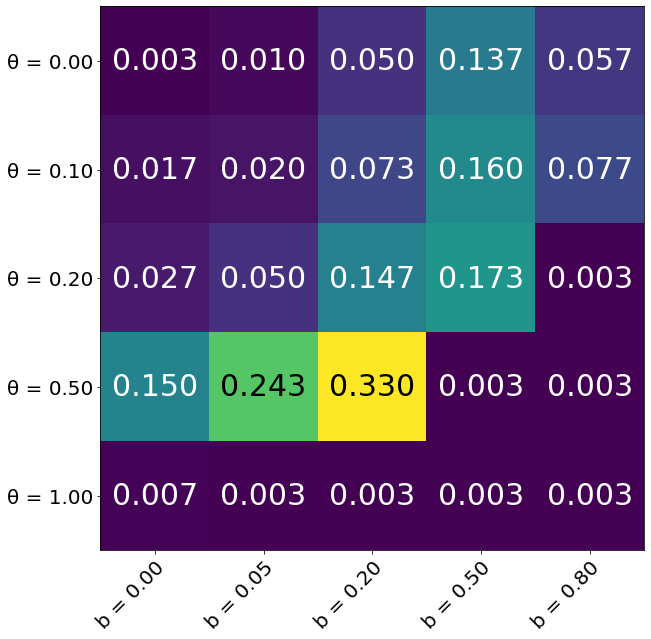

In [83]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(CCapacities)
ax.set_xticks(np.arange(len(θ_vals)), labels=xticklabels)
ax.set_yticks(np.arange(len(b_vals)), labels=yticklabels)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(θ_vals)):
    for j in range(len(b_vals)):
        color = 'w'
        if CCapacities[i][j] > 0.33*0.7:
            color = 'k'
        text = ax.text(j, i, "%.3f"%(CCapacities[i][j]),
                       ha="center", va="center", color=color,fontsize = 30)
plt.show()

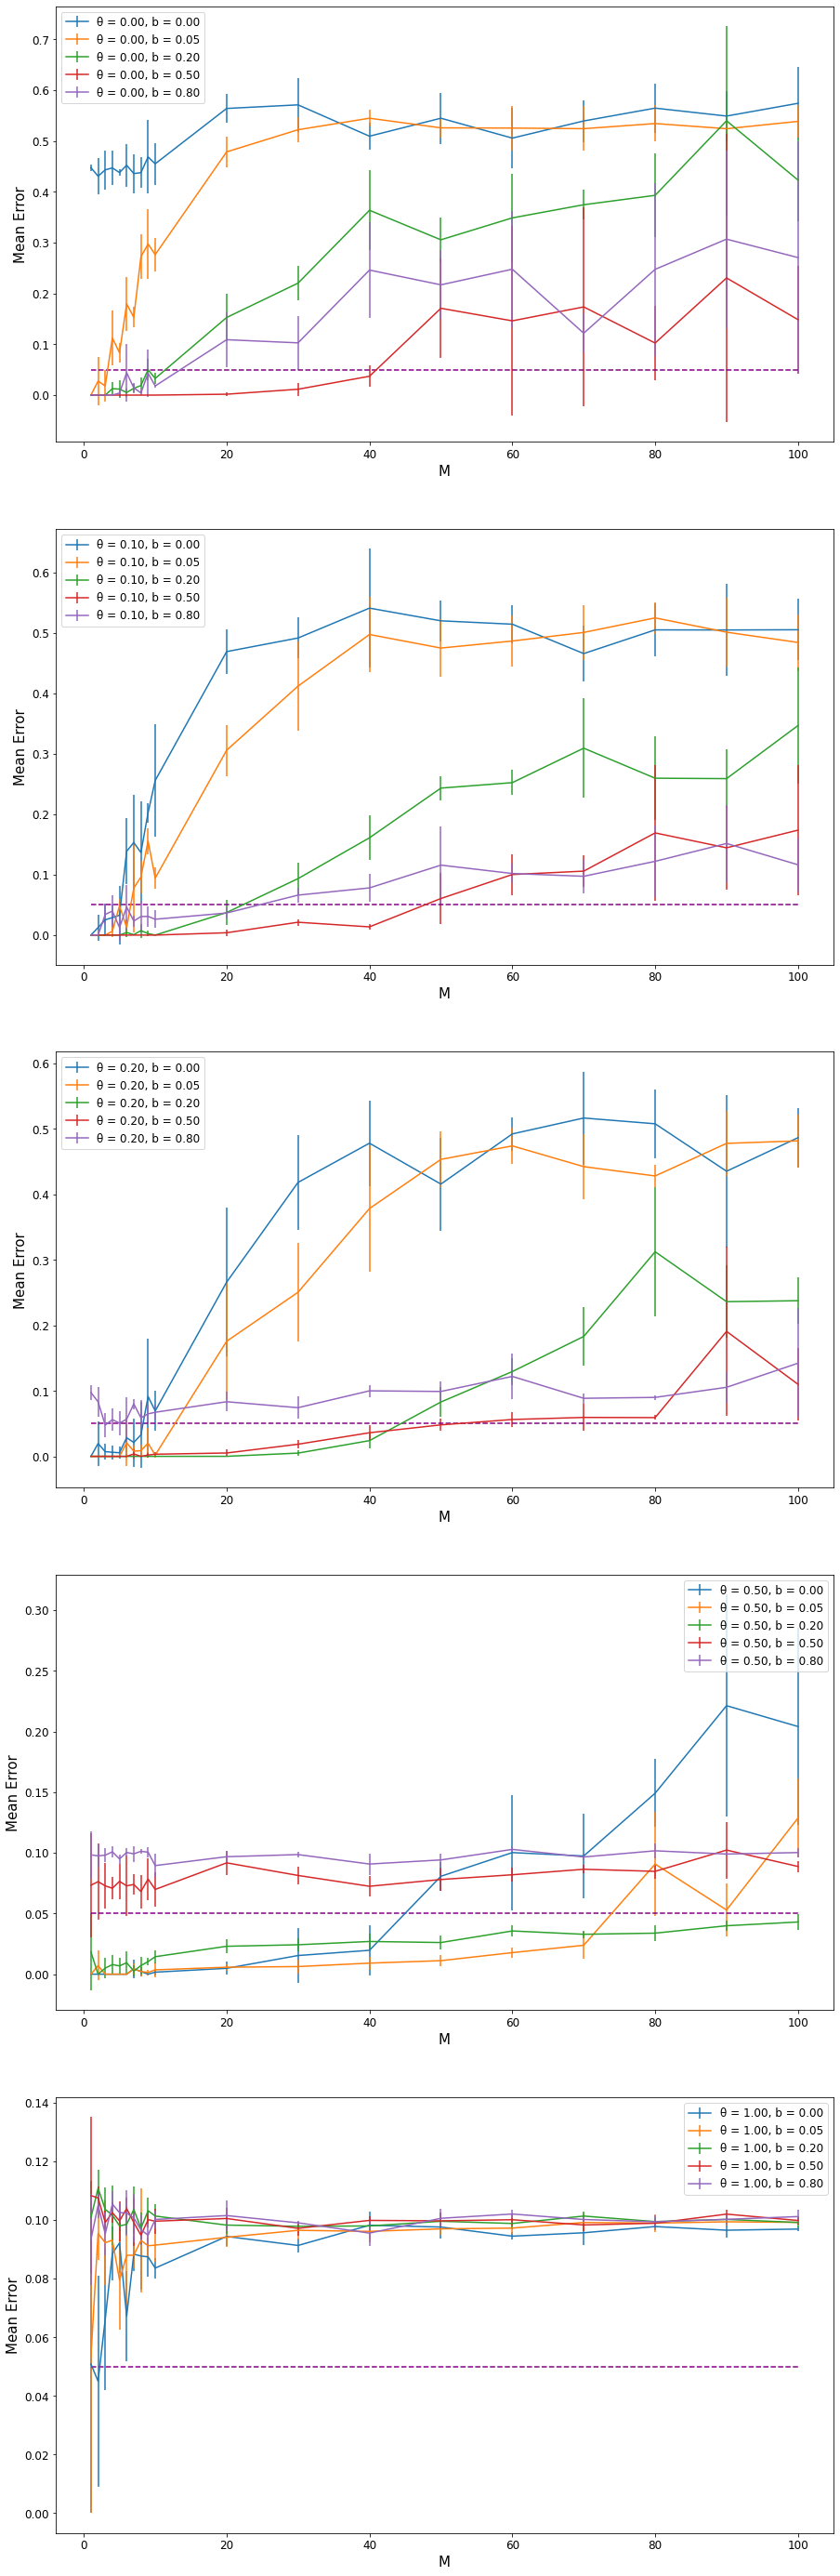

In [39]:
fig,ax = plt.subplots(len(θ_vals),figsize=(15,len(θ_vals)*10))
for i in range(len(θ_vals)):
    for j in range(len(b_vals)):  
        ax[i].errorbar(M_values,EEE_values[i][j],yerr = EEE_errors[i][j],label = "θ = %.2f, b = %.2f"%(θ_vals[i],b_vals[j]))
    ax[i].plot(M_values,0.05*np.ones(len(M_values)),'--',color = 'purple')
    ax[i].set_xlabel("M")
    ax[i].set_ylabel("Mean Error")
    ax[i].legend()
plt.show()